# Modeling 111001011 - drop features

In this notebook, we're specifically working on the dataset formed by dropping (31, 496, 524, 917, 1183, 1299) with the features ('LogGrLivArea', 'GrLivArea', 'TotalHouseArea', 'AreasSum') dropped.

In [1]:
import itertools
import numpy as np
import pandas as pd
import scipy
from scipy import optimize

pd.set_option('display.precision',20)
pd.set_option('display.max_colwidth',100)

from sklearn import linear_model, svm, tree
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, cross_val_score, \
                                    GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.neural_network import MLPRegressor
    
    
    
import xgboost as xgb

from time import time
from scipy.stats import randint as sp_randint

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

In [2]:
# def to compare goodness of fit on training set
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# run randomized search
def random_search(regr, param_dist, n_iter_search): 
    rs = RandomizedSearchCV(regr, param_distributions=param_dist, scoring = 'neg_mean_squared_error',
                                   n_jobs=-1, n_iter=n_iter_search, cv=kfold) #, verbose = 4)
    start = time()
    rs.fit(x_train, y_train)
    print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
    report(rs.cv_results_)

In [5]:
# run single parameter search (for ridge or lasso)
def single_search(regr, params):
    regr_results_df = pd.DataFrame(dtype = 'float64')
    count = 0
    for k, v in params.items():
        for val in v:
            regr.set_params(**{k: val})
            regr_results_df.loc[count, k] = val
            results = cross_val_score(regr, x_train, y_train, cv=kfold, scoring = 'neg_mean_squared_error')
            (regr_results_df.loc[count, 'RMSE'], regr_results_df.loc[count, 'std dev']) = \
                    (np.sqrt(-results.mean()), np.sqrt(results.std()))
            count += 1
    return regr_results_df

In [6]:
# test against validation set
def validate(regr):
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_validation)
    return rmse(y_validation, y_pred)

In [7]:
# Cross-validation sets
kfold = KFold(n_splits=10, random_state=7)

In [8]:
df = pd.read_csv("./input/train_tidy_111001011.csv")
df.drop(['LogGrLivArea', 'GrLivArea', 'TotalHouseArea', 'AreasSum'], axis=1, inplace=True)

In [9]:
ss = ShuffleSplit(n_splits=1, test_size=0.20, random_state=71)

X = df.values

for train_idx, validation_idx in ss.split(X):
    train_df = df.iloc[train_idx]
    validation_df = df.iloc[validation_idx]
    
y_validation = validation_df['SalePrice'].values
x_validation = validation_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values
y_train = train_df['SalePrice'].values
x_train = train_df.drop(['HouseId', 'SalePrice', 'GarageAge', 'GarageAgeLin'],axis=1).values

## Ridge regression

In [10]:
ridge_regr = linear_model.Ridge()

In [11]:
ridge_param = {'alpha': scipy.stats.expon(scale=10)}
random_search(ridge_regr, ridge_param, 20)

RandomizedSearchCV took 4.14 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 7.0843854750719801}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 6.7366274201383503}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 12.072096727116401}



,alpha,RMSE,std dev
0,1.0,0.11487178277813338279,0.06419544229461715545
1,2.0,0.11296992013784562525,0.06399755926899612646
2,3.0,0.11197644235991319195,0.06377843246580387759
3,4.0,0.11135128770368829532,0.06360887387690317141
4,5.0,0.11093310923731056206,0.06347973264869662124
5,6.0,0.11064837271350175252,0.06337997889795141115
6,7.0,0.11045656586597370208,0.06330160887543456738
13,14.0,0.11037167428247253442,0.06303420652307138716
7,8.0,0.11033283755951237004,0.06323903754987730830
12,13.0,0.11030518279829230888,0.06305658265464419987


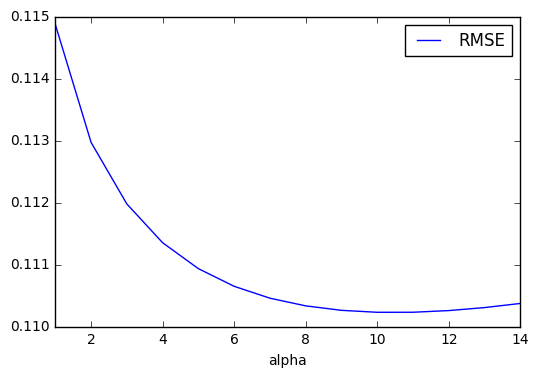

In [12]:
ridge_params = {'alpha': np.arange(1, 15, 1).tolist()}
ridge_df = single_search(ridge_regr, ridge_params)
ridge_df.plot(x = ['alpha'], y = ['RMSE'])
ridge_df.sort_values(['RMSE'], ascending = False)

In [13]:
ridge_regr = linear_model.Ridge(alpha = 10)

In [14]:
validate(ridge_regr)

0.11070767131297345

## Lasso

In [12]:
lasso_regr = linear_model.Lasso(max_iter=50000)

In [13]:
lasso_param = {'alpha': scipy.stats.expon(scale=0.001)}
random_search(lasso_regr, lasso_param, 20)

RandomizedSearchCV took 20.85 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00027274926882741885}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00037682978531351075}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00037874401674326062}



,alpha,RMSE,std dev
0,0.00010000000000000000,0.11305028680432099852,0.06478229425153293752
5,0.00060000000000000006,0.10999563848557580847,0.06356001385233701895
1,0.00020000000000000001,0.10984448622509347671,0.06408093973182399372
4,0.00050000000000000001,0.10957581591559435730,0.06339008624309465378
3,0.00040000000000000002,0.10936106403055412262,0.06341986147012759756
2,0.00030000000000000003,0.10925875594011522085,0.06359108164159600618


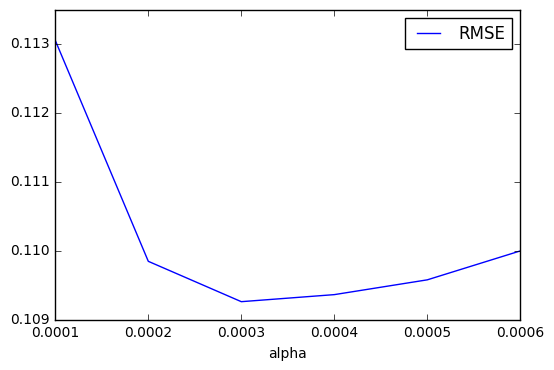

In [27]:
lasso_params = {'alpha': np.arange(0.0001, 0.0007, 0.0001).tolist()}
lasso_df = single_search(lasso_regr, lasso_params)
lasso_df.plot(x = ['alpha'], y = ['RMSE'])
lasso_df.sort_values(['RMSE'], ascending = False)

In [28]:
lasso_regr = linear_model.Lasso(alpha=0.0003, max_iter=50000)

In [29]:
validate(lasso_regr)

0.10648875969900122

## Lasso LARS

In [14]:
lassolars_regr = linear_model.LassoLars(max_iter=50000)

In [15]:
lassolars_param = {'alpha': scipy.stats.expon(scale=0.0001)}
random_search(lassolars_regr, lassolars_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 245 iterations, i.e. alpha=2.331e-05, with an active set of 195 regressors, and the smallest cholesky pivot element being 2.788e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 202 iterations, i.e. alpha=4.208e-05, with an active set of 156 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 283 iterations, i.e. alpha=1.172e-05, with an active set of 215 regressors, and the smallest cholesky pivot element being 2.980e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model

RandomizedSearchCV took 9.01 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 8.6373889661803437e-05}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00019142479983509476}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 8.0907091244415279e-05}



/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 96 iterations, i.e. alpha=1.502e-04, with an active set of 84 regressors, and the smallest cholesky pivot element being 1.490e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 113 iterations, i.e. alpha=1.143e-04, with an active set of 95 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/least_angle.py:309: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 114 iterations, i.e. alpha=1.137e-04, with an active set of 96 regressors, and the smallest cholesky pivot element being 2.581e-08
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/lea

,alpha,RMSE,std dev
0,0.00008000000000000001,0.10852895208533315519,0.06195480979814557004
1,0.00009000000000000001,0.10835388761054076667,0.06174891800520473234
2,0.00010000000000000000,0.10820166534117550694,0.06158447869268522668
3,0.00011000000000000000,0.10808054070160443005,0.06136550652765247055
4,0.00012000000000000000,0.10799329867546698936,0.06113378046242592956
7,0.00015000000000000001,0.10796189374775323755,0.06084444819972678609
5,0.00013000000000000002,0.10796048262878432666,0.06096899905843435052
6,0.00013999999999999999,0.10795680538867133413,0.06087169785719322157


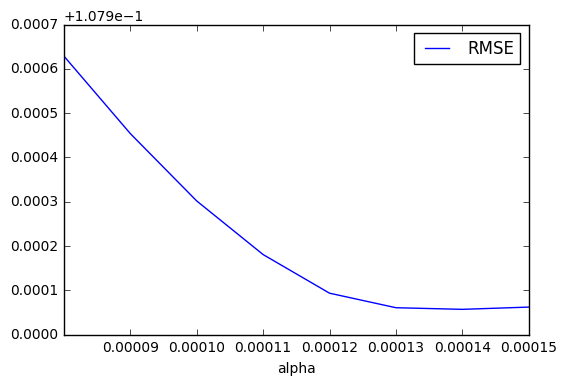

In [30]:
lassolars_params = {'alpha': np.arange(0.00008, 0.00016, 0.00001).tolist()}
lassolars_df = single_search(lassolars_regr, lassolars_params)
lassolars_df.plot(x = ['alpha'], y = ['RMSE'])
lassolars_df.sort_values(['RMSE'], ascending = False)

In [31]:
lassolars_regr = linear_model.LassoLars(alpha=0.00014, max_iter=50000)

In [32]:
validate(lassolars_regr)

0.1027311912225994

## Elastic Net

In [16]:
elnet_regr = linear_model.ElasticNet(max_iter=15000, random_state=7)

In [17]:
elnet_param =  {'alpha': scipy.stats.expon(scale=0.001), 'l1_ratio': scipy.stats.truncnorm(0, 1, loc=0.5, scale=0.25)}
random_search(elnet_regr, elnet_param, 20)

/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fit

RandomizedSearchCV took 70.33 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00057428335529804086, 'l1_ratio': 0.53045631598691756}

Model with rank: 2
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00051033751323643732, 'l1_ratio': 0.50785659869599487}

Model with rank: 3
Mean validation score: -0.012 (std: 0.004)
Parameters: {'alpha': 0.00045813128578835774, 'l1_ratio': 0.54025326274403185}



,alpha,RMSE,std dev
0,0.00010000000000000000,0.11582818033754818665,0.06420478939929336049
1,0.00020000000000000001,0.11239961215004995454,0.06462098264016487292
2,0.00030000000000000003,0.11046489539102750943,0.06427326313565084881
3,0.00040000000000000002,0.10959404483259811702,0.06391033867320275452
4,0.00050000000000000001,0.10921340971150765575,0.06345583144376297502
6,0.00070000000000000010,0.10917340205381198537,0.06299987870697272563
5,0.00060000000000000006,0.10910759586466349524,0.06310425728342253238


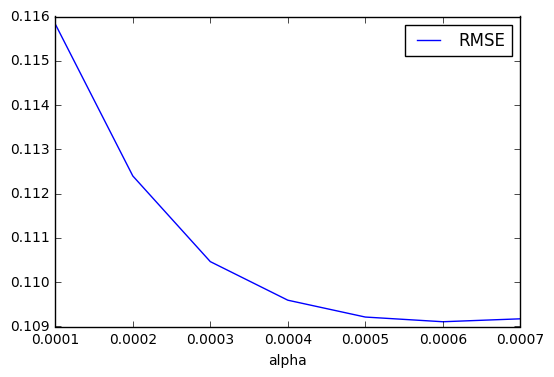

In [33]:
elnet_regr = linear_model.ElasticNet(alpha=0.00038, l1_ratio=0.5, max_iter=15000, random_state=7)
elnet_params = {'alpha': np.arange(0.0001, 0.0008, 0.0001).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['alpha'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

,l1_ratio,RMSE,std dev
0,0.10000000000000000555,0.11282564607963881109,0.06428849514529708098
1,0.20000000000000001110,0.11089984172682001984,0.06430167363686484228
2,0.30000000000000004441,0.10978080418228033932,0.06387102378169429162
8,0.90000000000000002220,0.10971070978345966174,0.06338596309749515434
7,0.80000000000000004441,0.10945270539604975979,0.06322077028908336394
6,0.70000000000000006661,0.10929574900570927787,0.06315486324150187958
3,0.40000000000000002220,0.10927195971399075725,0.06342617563343881659
5,0.59999999999999997780,0.10918376019133871346,0.06305040959252324051
4,0.50000000000000000000,0.10910759586466342586,0.06310425728342251850


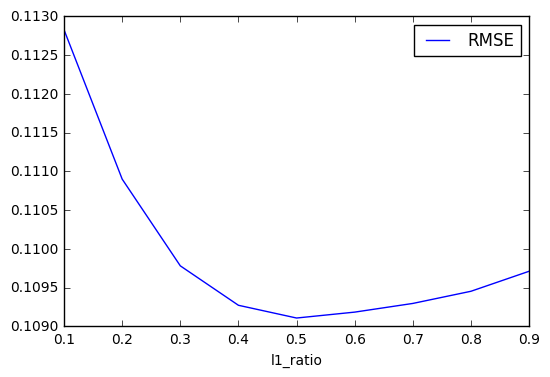

In [34]:
elnet_regr = linear_model.ElasticNet(alpha=0.0006, max_iter=15000, random_state=7)
elnet_params = {'l1_ratio': np.arange(0.1, 1, 0.1).tolist()}
elnet_df = single_search(elnet_regr, elnet_params)
elnet_df.plot(x = ['l1_ratio'], y = ['RMSE'])
elnet_df.sort_values(['RMSE'], ascending = False)

In [35]:
elnet_regr = linear_model.ElasticNet(alpha=0.0006, l1_ratio=0.5, max_iter=15000, random_state=7)

In [36]:
validate(elnet_regr)

0.10739691489786372

## Random Forest

In [18]:
rf_regr = RandomForestRegressor(n_jobs=-1, random_state = 7)

In [19]:
rf_param =  {'n_estimators': scipy.stats.randint(50,400), 'max_depth': scipy.stats.randint(2,20), 
             'max_features': scipy.stats.randint(5,30)}
random_search(rf_regr, rf_param, 20)

RandomizedSearchCV took 72.01 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.016 (std: 0.004)
Parameters: {'max_features': 26, 'n_estimators': 367, 'max_depth': 17}

Model with rank: 2
Mean validation score: -0.016 (std: 0.004)
Parameters: {'max_features': 26, 'n_estimators': 394, 'max_depth': 13}

Model with rank: 3
Mean validation score: -0.016 (std: 0.004)
Parameters: {'max_features': 27, 'n_estimators': 370, 'max_depth': 15}



,n_estimators,RMSE,std dev
0,50.0,0.12427681795889083949,0.05856550691664401398
1,100.0,0.12379211344884299972,0.05882806069646809993
2,150.0,0.12246252082520693583,0.05884555692478173061
3,200.0,0.12242605777968558478,0.05967367840647457011
4,250.0,0.12240043918374540755,0.06000008400362424887
5,300.0,0.12235103114818585146,0.05937255848670843633
9,500.0,0.12229827528441987450,0.05941654296536200835
7,400.0,0.12228956716536000526,0.05942086882215860677
6,350.0,0.12228378822021442052,0.05950721473121291932
8,450.0,0.12223425719923203259,0.05948141083424856451


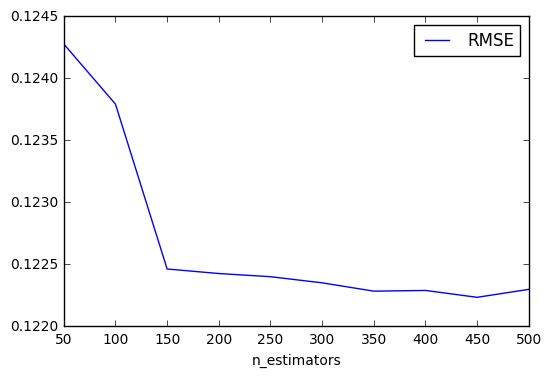

In [50]:
rf_regr = RandomForestRegressor(n_estimators = 367, max_depth = 26, max_features = 75, random_state = 7)
rf_params = {'n_estimators': np.arange(50, 550, 50).tolist()}
rf_df = single_search(rf_regr, rf_params)
rf_df.plot(x = ['n_estimators'], y = ['RMSE'])
rf_df.sort_values(['RMSE'], ascending = False)

In [53]:
rf_regr = RandomForestRegressor(n_estimators = 450, max_depth = 26, max_features = 75, random_state = 7)

In [54]:
validate(rf_regr)

0.13092064609418047

## Support Vector Regressor

In [20]:
svr_regr = svm.SVR(cache_size=200, degree=3, max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [21]:
svr_param = {'C': scipy.stats.expon(scale=1), 'gamma': scipy.stats.expon(scale=.1),
              'kernel': ['rbf']}
random_search(svr_regr, svr_param, 20)

RandomizedSearchCV took 20.88 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.014 (std: 0.004)
Parameters: {'kernel': 'rbf', 'C': 0.67597011870716484, 'gamma': 0.011340042071684897}

Model with rank: 2
Mean validation score: -0.014 (std: 0.004)
Parameters: {'kernel': 'rbf', 'C': 1.3286954913099536, 'gamma': 0.013227480861406815}

Model with rank: 3
Mean validation score: -0.014 (std: 0.004)
Parameters: {'kernel': 'rbf', 'C': 0.67023037138144692, 'gamma': 0.0042080397372254129}



,C,RMSE,std dev
0,0.10000000000000000555,0.14687707067028243912,0.06388736626646315808
1,0.20000000000000001110,0.13113098202700343431,0.06331754737979240766
2,0.30000000000000004441,0.12507306434655157679,0.06224319264830337206
3,0.40000000000000002220,0.12200658666552553766,0.06210737351436886045
4,0.50000000000000000000,0.12015266193919979520,0.06221366452768991445
5,0.59999999999999997780,0.11885585721550233351,0.06244365463156519719
6,0.70000000000000006661,0.11802135771613710136,0.06244856624610922724
7,0.80000000000000004441,0.11759739611995417841,0.06232863494518232905
8,0.90000000000000002220,0.11725003991415595961,0.06220536084087203293
9,1.00000000000000000000,0.11692552119731854099,0.06224192812313115997


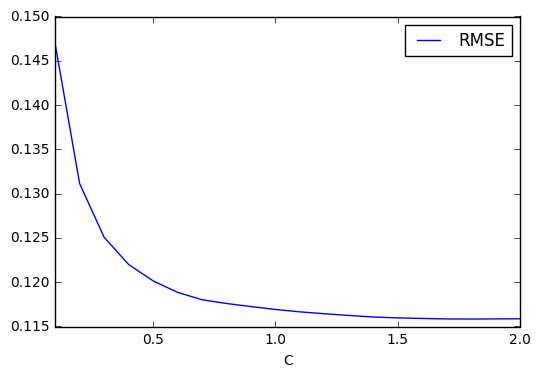

In [44]:
svr_regr = svm.SVR(C=0.68, cache_size=200, coef0=0.0, degree=3, gamma=0.008,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
svr_params = {'C': np.arange(0.1, 2.1, 0.1).tolist()}
svr_df = single_search(svr_regr, svr_params)
svr_df.plot(x = ['C'], y = ['RMSE'])
svr_df.sort_values(['RMSE'], ascending = False)

In [55]:
svr_regr = svm.SVR(C=1.8, cache_size=200, coef0=0.0, degree=3, gamma=0.008,
                        kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [56]:
validate(svr_regr)

0.12167235049411367

## Orthogonal Matching Pursuit

In [22]:
omp_regr = linear_model.OrthogonalMatchingPursuit()

In [23]:
omp_param = {'n_nonzero_coefs': scipy.stats.randint(20,120)}
random_search(omp_regr, omp_param, 20)

RandomizedSearchCV took 2.27 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.013 (std: 0.003)
Parameters: {'n_nonzero_coefs': 90}

Model with rank: 2
Mean validation score: -0.013 (std: 0.003)
Parameters: {'n_nonzero_coefs': 96}

Model with rank: 3
Mean validation score: -0.014 (std: 0.003)
Parameters: {'n_nonzero_coefs': 97}



,n_nonzero_coefs,RMSE,std dev
18,113.0,0.11635461557324669468,0.05525759511489178322
19,114.0,0.11633665163796862163,0.05522863621544055190
17,112.0,0.11627851177965460583,0.05523542618074944038
2,97.0,0.11623042452590863494,0.05544194037389812979
14,109.0,0.11621013457119974688,0.05623034175861326561
16,111.0,0.11620422502234546702,0.05506828421018861858
15,110.0,0.11615534270940745809,0.05585391740441771752
1,96.0,0.11596530417585741712,0.05539956910250017075
0,95.0,0.11594583769019069230,0.05531592242154659972
3,98.0,0.11584298364201237042,0.05502734443771784695


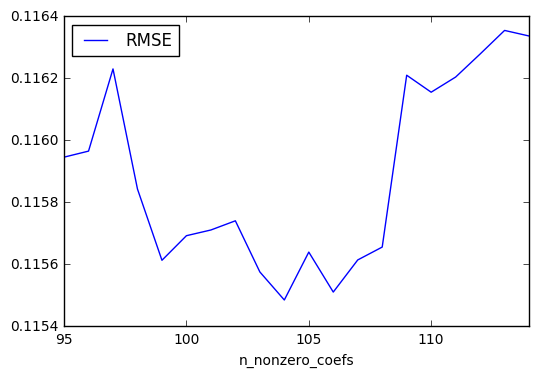

In [40]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=90)
omp_params = {'n_nonzero_coefs': np.arange(95, 115, 1).tolist()}
omp_df = single_search(omp_regr, omp_params)
omp_df.plot(x = ['n_nonzero_coefs'], y = ['RMSE'])
omp_df.sort_values(['RMSE'], ascending = False)

In [57]:
omp_regr = linear_model.OrthogonalMatchingPursuit(n_nonzero_coefs=104)

In [58]:
validate(omp_regr)

0.10617371711996455

## XGBoost

In [24]:
xgb_regr = xgb.XGBRegressor(seed = 42, nthread = -1, silent = 1)
xgb_param = {'max_depth': scipy.stats.randint(1,10), # Max. Depth [1,∞]
             'min_child_weight': scipy.stats.expon(scale=1), # Min. Child Weight [0,∞]
             'gamma': scipy.stats.expon(scale=1), # Minimum Split Loss, gamma [0,∞]
             'subsample': scipy.stats.uniform(0, 1), # Subsample Ratio of the training instance [0,1]
             'colsample_bytree': scipy.stats.uniform(0, 1), # Subsample Ratio of columns [0,1]
             'reg_alpha': scipy.stats.expon(scale=1), # L1 regularization, alpha [0,∞]
             'reg_lambda': scipy.stats.expon(scale=1), # L2 regularization, lambda [0,∞]
             'learning_rate': scipy.stats.uniform(0, 1), # Step size shrinkage (learning rate) [0,1]
             'n_estimators': scipy.stats.randint(50,500) # Number of boosted trees, n_estimators
            }
random_search(xgb_regr, xgb_param, 20)

RandomizedSearchCV took 3026.17 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.015 (std: 0.004)
Parameters: {'reg_alpha': 0.14946132842298368, 'colsample_bytree': 0.42769267737130268, 'learning_rate': 0.18575315230432843, 'min_child_weight': 0.40182436543396405, 'n_estimators': 494, 'subsample': 0.85749593371821786, 'reg_lambda': 0.14521634166888167, 'max_depth': 5, 'gamma': 0.055509459121869019}

Model with rank: 2
Mean validation score: -0.019 (std: 0.003)
Parameters: {'reg_alpha': 1.775676242237308, 'colsample_bytree': 0.64907554457678907, 'learning_rate': 0.031835834799785467, 'min_child_weight': 0.13792596812989941, 'n_estimators': 190, 'subsample': 0.66463327015631735, 'reg_lambda': 1.2999788275145847, 'max_depth': 6, 'gamma': 0.063484776956160754}

Model with rank: 3
Mean validation score: -0.020 (std: 0.004)
Parameters: {'reg_alpha': 0.56818079645458708, 'colsample_bytree': 0.40933929079942766, 'learning_rate': 0.13257402296073084, 'm

,n_estimators,RMSE,std dev
5,1050.0,0.11278493525309782330,0.06337620987786941884
1,850.0,0.11277265670670931497,0.06328022295779603401
0,800.0,0.11276261219096579691,0.06348915811691718813
2,900.0,0.11275253860181083665,0.06329645129768771139
10,1300.0,0.11273861849367931842,0.06295034735276455740
6,1100.0,0.11273439782586705538,0.06323512775223676108
3,950.0,0.11272126485294677034,0.06324535034597630889
8,1200.0,0.11272054141010726114,0.06310876348967765781
9,1250.0,0.11271566752240953779,0.06301665862953427510
4,1000.0,0.11271419340401429843,0.06332747370344250781


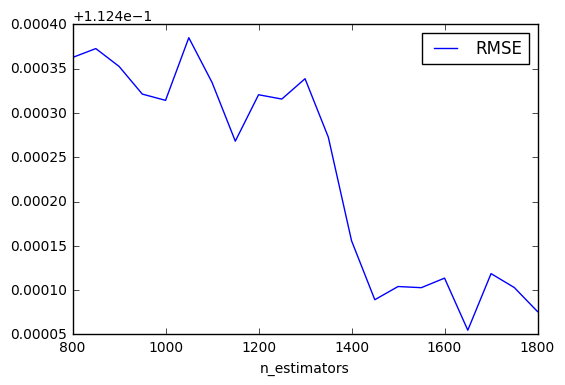

In [70]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 2, 
    min_child_weight = 4.6,
    gamma = 0.04,
    subsample = 0.6,
    colsample_bytree = 0.7,
    reg_alpha = 0.4,
    reg_lambda = 0.1, 
    learning_rate = 0.06,
    n_estimators = 494,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)
xgb_params = {'n_estimators': np.arange(800, 1850, 50).tolist()}
xgb_df = single_search(xgb_regr, xgb_params)
xgb_df.plot(x = ['n_estimators'], y = ['RMSE'])
xgb_df.sort_values(['RMSE'], ascending = False)

In [71]:
xgb_regr = xgb.XGBRegressor(
    max_depth = 2, 
    min_child_weight = 4.6,
    gamma = 0.04,
    subsample = 0.6,
    colsample_bytree = 0.7,
    reg_alpha = 0.4,
    reg_lambda = 0.1, 
    learning_rate = 0.06,
    n_estimators = 1650,
    objective='reg:linear', 
    seed = 42,
    nthread = -1,
    silent = 1)

In [72]:
validate(xgb_regr)

0.1122552191631449

## MLP Regressor

In [25]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(100, ),
                        alpha=0.0001, 
                        tol=0.0001, 
                        max_iter=200)

In [26]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641)
mlp_param = {'hidden_layer_sizes': scipy.stats.randint(50,500), # size of a single hidden layer
             'alpha': scipy.stats.expon(scale=0.0001), # L2 regularization,  [0,∞]
             'tol': scipy.stats.expon(scale=0.0001), # Minimum improvement in loss fun. during training
             'max_iter': scipy.stats.uniform(200, 400), # Maximum number of iterations of solver
            }
random_search(mlp_regr, mlp_param, 20)

RandomizedSearchCV took 802.17 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: -0.019 (std: 0.004)
Parameters: {'alpha': 0.000259801956460835, 'max_iter': 503.68955049365047, 'tol': 0.00038100956368695234, 'hidden_layer_sizes': 79}

Model with rank: 2
Mean validation score: -0.019 (std: 0.003)
Parameters: {'alpha': 2.9655059768918286e-05, 'max_iter': 359.49452540724144, 'tol': 5.1627326681963597e-05, 'hidden_layer_sizes': 455}

Model with rank: 3
Mean validation score: -0.020 (std: 0.004)
Parameters: {'alpha': 3.5630479909229302e-05, 'max_iter': 278.44308822284239, 'tol': 8.2798240896678598e-05, 'hidden_layer_sizes': 263}



,hidden_layer_sizes,RMSE,std dev
3,4.0,0.12849635178960150395,0.06855433005071789876
9,10.0,0.12543453665307705003,0.06134341391450377073
7,8.0,0.12481477791499318020,0.06365630810321602773
8,9.0,0.12445000596152740180,0.06354261051495883883
4,5.0,0.12369454839433133286,0.06702506832170232465
5,6.0,0.12328953948989600231,0.06546624482353433083
6,7.0,0.12223955667900790467,0.06259196245209658338
1,2.0,0.12221318643714368379,0.06279871614449603068
10,11.0,0.12095475335288854990,0.05925174837991468990
2,3.0,0.12071240449316603116,0.06547408963416227745


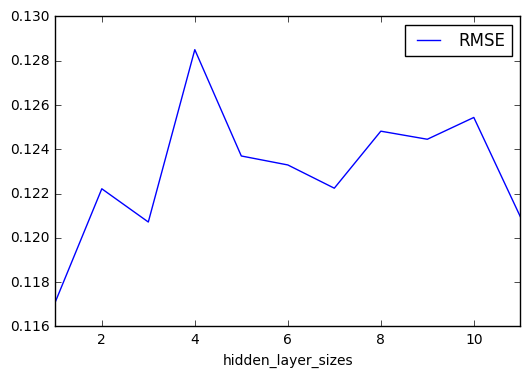

In [62]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(1, ),
                        alpha=0.0007, 
                        tol=0.0005, 
                        max_iter=200)
mlp_params = {'hidden_layer_sizes': np.arange(1, 12, 1).tolist()}
mlp_df = single_search(mlp_regr, mlp_params)
mlp_df.plot(x = ['hidden_layer_sizes'], y = ['RMSE'])
mlp_df.sort_values(['RMSE'], ascending = False)

In [64]:
mlp_regr = MLPRegressor(activation='relu', solver='lbfgs', random_state=641,
                        hidden_layer_sizes=(1, ),
                        alpha=0.0007, 
                        tol=0.0005, 
                        max_iter=200)

In [65]:
validate(mlp_regr)

0.11333103023667514